In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from capstone.utils import read_file
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [2]:
class Metrics:

    def __init__(self):
        self.metrics = pd.DataFrame(columns=[
            "Sharpe Ratio", "Cumulative Return", "Annualized Return", "Annualized Volatility"
        ])

    def calculate(self, data):
        for col in data.columns:
            cum_ret = self._cumulative_returns(data[col])
            sharpe = self._sharpe(data[col])
            ann_ret = self._annualized_return(data[col])
            ann_std = self._annualized_risk(data[col])
            metrics = {
                "Cumulative Return": cum_ret,
                "Sharpe Ratio": sharpe,
                "Annualized Return": ann_ret,
                "Annualized Volatility": ann_std
            }
            self.metrics.loc[col] = metrics
        return self.metrics.sort_values(by=["Sharpe Ratio", "Cumulative Return"], ascending=False)
    
    @staticmethod
    def _cumulative_returns(data):
        return data.cumsum().iloc[-1]

    @staticmethod
    def _sharpe(data):
        return (data.mean() * 252) / (data.std() * np.sqrt(252))
    
    @staticmethod
    def _annualized_return(data):
        return data.mean() * 252
    
    @staticmethod
    def _annualized_risk(data):
        return data.std() * np.sqrt(252)
    

In [307]:
df = read_file("data", "master_df", index_col="Date")
snp_prices = read_file("data", "snp_prices", index_col="Date")
sectors_file = read_file("data", "stocks_by_sector", index_col=0)

In [308]:
snp_log_returns = np.log(snp_prices).diff().reindex(df.index)
snp_log_returns.head(3)

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-17,0.002967,-0.019324,0.002799,0.003784,0.009612,0.005134,-0.009604,-0.004150,-0.030383,-0.002615,...,0.014786,-0.012140,-0.006565,0.005317,0.005626,0.006231,-0.013457,-0.001865,-0.027231,-0.005779
2006-11-20,-0.000296,0.006706,0.007196,0.001886,-0.000143,-0.016639,-0.003383,0.001187,-0.025348,-0.005453,...,-0.002740,-0.000470,0.020552,0.000000,-0.008934,-0.010302,0.012343,-0.017483,0.000845,0.000000
2006-11-21,-0.003266,0.017227,0.024334,-0.005670,-0.002574,-0.002316,0.029575,-0.013806,0.006249,-0.003652,...,-0.004751,-0.000157,0.005432,0.002647,0.013167,0.011853,-0.000638,0.004872,-0.001972,-0.007335


In [4]:
sectors = sectors_file["GICS Sector"].unique()
sectors = [sector.upper().replace(" ", "_") for sector in sectors]
sectors = [sector for sector in sectors if sector in df.columns]
sectors

['INDUSTRIALS',
 'HEALTH_CARE',
 'INFORMATION_TECHNOLOGY',
 'COMMUNICATION_SERVICES',
 'CONSUMER_STAPLES',
 'UTILITIES',
 'FINANCIALS',
 'MATERIALS',
 'REAL_ESTATE',
 'CONSUMER_DISCRETIONARY',
 'ENERGY']

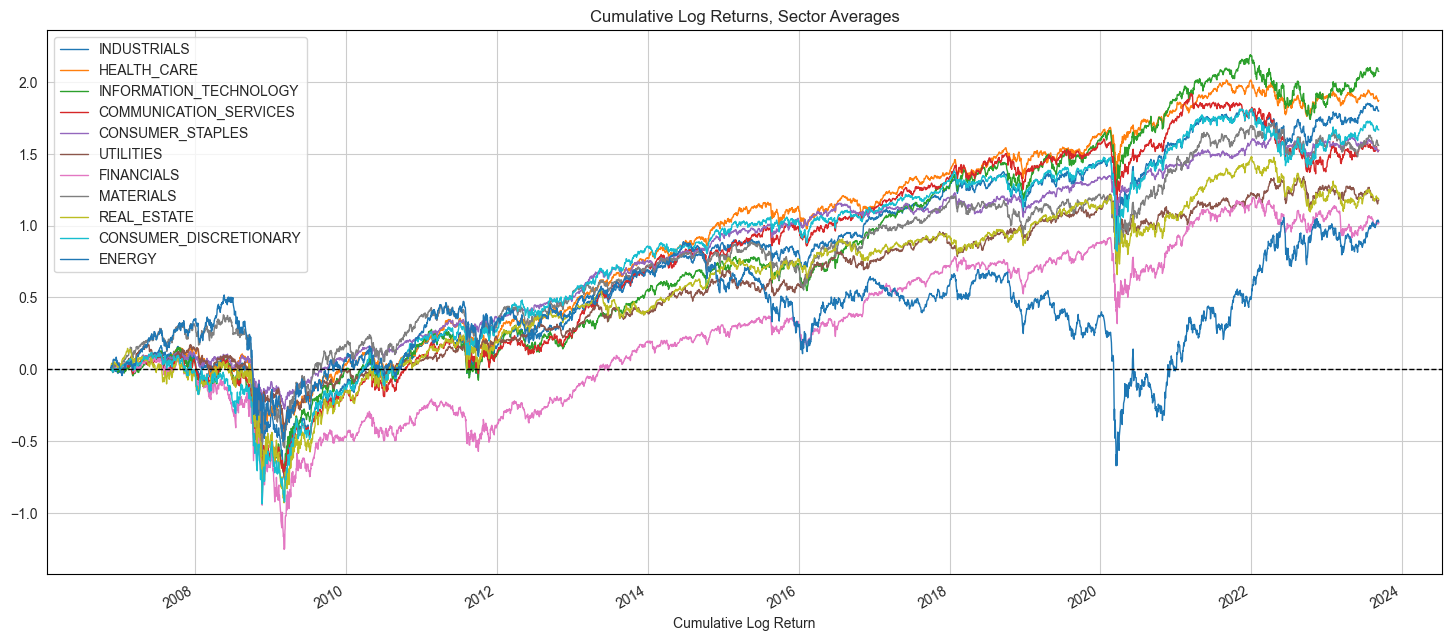

In [5]:
df[sectors].cumsum().plot(figsize=(18, 8))
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns, Sector Averages")
plt.xlabel("Cumulative Log Return")
plt.show()

In [6]:
metrics = Metrics()
metrics.calculate(df[sectors])

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
CONSUMER_STAPLES,0.591744,1.523074,0.090736,0.153337
HEALTH_CARE,0.575965,1.871483,0.111493,0.193575
INFORMATION_TECHNOLOGY,0.485301,2.072833,0.123488,0.254457
INDUSTRIALS,0.454374,1.797568,0.107089,0.235685
COMMUNICATION_SERVICES,0.400580,1.525032,0.090853,0.226804
CONSUMER_DISCRETIONARY,0.390779,1.666041,0.099254,0.253989
MATERIALS,0.358685,1.558253,0.092832,0.258812
UTILITIES,0.352107,1.177060,0.070123,0.199152
REAL_ESTATE,0.235530,1.183810,0.070525,0.299430
FINANCIALS,0.206089,1.017309,0.060606,0.294074


In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

y = df[sectors]
X = df[df.columns[~df.columns.isin(y.columns)]]

pca_pipe = PCA(n_components=.8, random_state=42)

X_pca = pd.DataFrame(
    pca_pipe.fit_transform(X), 
    index=X.index
)

X_pca.columns = [f"PC{i+1}" for i in range(len(X_pca.columns))]

X_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Date,,,,,,,,,,,,,,,,
2006-11-17,32.320730,35.895600,-3.408037,16.920103,8.897070,5.306509,-14.752822,7.000593,2.122184,-3.519747,4.344480,-5.230741,6.938870,0.997013,2.141179,4.982380
2006-11-20,23.871599,39.487046,-7.599920,31.140819,6.781338,4.279855,-18.035516,9.277180,0.466524,-2.752668,4.514301,-3.721221,5.697221,2.772938,2.737853,4.366742
2006-11-21,26.745991,38.596983,-7.811845,25.698286,7.662696,6.923170,-15.090583,9.548668,5.258722,-3.610646,-1.678663,-5.278074,4.405119,2.012132,1.797476,1.822770


In [239]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Ridge Regression: L2 regularization can help in case features are correlated.
# Random state ensures reproducibility.
ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=1, random_state=42))

# ElasticNet: Combines L1 and L2 regularization. Useful if the feature space is large and sparse.
# Random state ensures reproducibility.
elastic_net_pipe = make_pipeline(StandardScaler(), ElasticNet(alpha=1, l1_ratio=0.5, random_state=42))

# DecisionTreeRegressor: Captures non-linear relationships. Pruned to avoid overfitting.
# Random state ensures reproducibility.
decision_tree_pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=3, random_state=42))

# KNeighborsRegressor: Can capture local patterns in the data. 
# Scaling is essential as KNN is sensitive to varying scales among features.
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5))

# Support Vector Regression (SVR): Effective for non-linear patterns. 
# The RBF kernel is commonly used in financial time-series.
# Scaling is important as SVR is sensitive to feature scales.
svr_pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1, gamma='auto'))

# RandomForestRegressor: Ensemble of decision trees, reduces overfitting and captures complexity.
# n_estimators sets the number of trees in the ensemble, and max_depth controls the depth of each tree.
# Random state ensures reproducibility.
random_forest = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)


# Store the models in a dictionary for easy access
models = {
    'Ridge': ridge_pipe,
    'ElasticNet': elastic_net_pipe,
    'DecisionTree': decision_tree_pipe,
    'KNN': knn_pipe,
    'SVR': svr_pipe,
    'RandomForest': random_forest
}

In [240]:
def overestimation_loss(y_true, y_pred):
    residual = y_true - y_pred
    underpred_penalty = 2.0
    loss = np.where(residual < 0, underpred_penalty * (-residual), residual)
    return np.mean(loss)

forecast = 252

X_pca_shifted = X_pca.shift(forecast).dropna()
y_all = df[sectors].reindex(X_pca_shifted.index)

preds = {model: pd.DataFrame() for model in models.keys()}
oels = {model: pd.DataFrame() for model in models.keys()}

for sector in tqdm(y_all.columns):

    for name, model in models.items():

        X = X_pca_shifted.copy()
        y = y_all[sector]

        for i in range(forecast, len(y), forecast):
            
            X_train = X.iloc[i-forecast:i]
            X_test = X.iloc[i:i+forecast]
            y_train = y.iloc[i-forecast:i]
            y_test = y.iloc[i:i+forecast]
            
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)

            preds[name].loc[X_test.index.min(), sector] = np.mean(y_hat) * 252
            oels[name].loc[X_test.index.min(), sector] = overestimation_loss(y_test, y_hat)

        preds[name][sector] = preds[name][sector].astype(float)
        oels[name][sector] = oels[name][sector].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

In [241]:
model_preds = {model: pd.Series(pred.idxmax(axis=1), name=model) for model, pred in preds.items()}
model_preds = pd.concat([pred for pred in model_preds.values()], axis=1)
model_preds.head()

,Ridge,ElasticNet,DecisionTree,KNN,SVR,RandomForest
2008-11-19,UTILITIES,CONSUMER_STAPLES,COMMUNICATION_SERVICES,UTILITIES,UTILITIES,UTILITIES
2009-11-19,COMMUNICATION_SERVICES,CONSUMER_DISCRETIONARY,FINANCIALS,INFORMATION_TECHNOLOGY,UTILITIES,FINANCIALS
2010-11-19,MATERIALS,CONSUMER_DISCRETIONARY,CONSUMER_DISCRETIONARY,ENERGY,CONSUMER_DISCRETIONARY,CONSUMER_DISCRETIONARY
2011-11-18,ENERGY,ENERGY,CONSUMER_DISCRETIONARY,ENERGY,REAL_ESTATE,REAL_ESTATE
2012-11-21,HEALTH_CARE,CONSUMER_DISCRETIONARY,HEALTH_CARE,INDUSTRIALS,FINANCIALS,FINANCIALS


In [244]:
mean_oels = {model: pd.Series(oel.median(axis=1), name=model) for model, oel in oels.items()}
mean_oels = pd.concat([oel for oel in mean_oels.values()], axis=1)

best_models = mean_oels.idxmin(axis=1)
best_models

2008-11-19      ElasticNet
2009-11-19      ElasticNet
2010-11-19      ElasticNet
2011-11-18      ElasticNet
2012-11-21      ElasticNet
2013-11-21      ElasticNet
2014-11-21             SVR
2015-11-23      ElasticNet
2016-11-22      ElasticNet
2017-11-22             SVR
2018-11-23    RandomForest
2019-11-25    RandomForest
2020-11-24      ElasticNet
2021-11-24           Ridge
2022-11-25      ElasticNet
dtype: object

In [311]:
sectors_file_refmt = sectors_file.copy()

sectors_file_refmt['GICS Sector'] = \
    sectors_file_refmt["GICS Sector"].apply(lambda s: str(s).upper().replace(" ", "_"))

results = pd.DataFrame(
    columns=["SELECTED_MODEL", "SELECTED_SECTOR", "AVAILABLE_STOCKS"],
    index = best_models.index
)

for date in best_models.index:
    best_model = best_models.loc[date]
    selected_sector = model_preds.loc[date, best_model]
    results.loc[date, "SELECTED_MODEL"] = best_model
    results.loc[date, "SELECTED_SECTOR"] = selected_sector
    selected_sector = results.loc[date, "SELECTED_SECTOR"]
    sector_constituents = \
        sectors_file_refmt[
            sectors_file_refmt["GICS Sector"] == selected_sector
        ]["Symbol"].str.replace(".", "-")
    sector_constituents = [c for c in sector_constituents if c in snp_log_returns.columns]
    results.loc[date, "AVAILABLE_STOCKS"] = ' '.join(sector_constituents)

results["AVAILABLE_STOCKS"] = results["AVAILABLE_STOCKS"].apply(lambda s: np.array(s.split()))
results

,SELECTED_MODEL,SELECTED_SECTOR,AVAILABLE_STOCKS
2008-11-19,ElasticNet,CONSUMER_STAPLES,"[ADM, MO, BF-B, BG, CPB, CHD, CLX, KO, CL, CAG..."
2009-11-19,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM..."
2010-11-19,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM..."
2011-11-18,ElasticNet,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."
2012-11-21,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM..."
2013-11-21,ElasticNet,COMMUNICATION_SERVICES,"[ATVI, GOOGL, GOOG, T, CMCSA, DIS, EA, IPG, LY..."
2014-11-21,SVR,UTILITIES,"[AES, LNT, AEE, AEP, ATO, CNP, CMS, ED, D, DTE..."
2015-11-23,ElasticNet,COMMUNICATION_SERVICES,"[ATVI, GOOGL, GOOG, T, CMCSA, DIS, EA, IPG, LY..."
2016-11-22,ElasticNet,INFORMATION_TECHNOLOGY,"[ACN, ADBE, AKAM, AMD, APH, ADI, ANSS, AAPL, A..."
2017-11-22,SVR,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."


In [314]:
def port_std(weights, returns):
    cov = returns.cov() * 252
    return np.sqrt(weights @ cov @ weights.T)

def port_sharpe(weights, returns):
    exp_rets = weights @ returns.T
    exp_ret = np.mean(exp_rets) * 252
    risk = port_std(weights, returns)
    return exp_ret / risk

results["EW_SHARPE"] = np.nan

for date in results.index:
    selected_stocks = results.loc[date, "AVAILABLE_STOCKS"]
    weights = np.array([1/len(selected_stocks)] * len(selected_stocks))
    past_returns = snp_log_returns[selected_stocks].loc[:date]
    results.loc[date, "EW_SHARPE"] = port_sharpe(weights, past_returns)

results

,SELECTED_MODEL,SELECTED_SECTOR,AVAILABLE_STOCKS,EW_SHARPE
2008-11-19,ElasticNet,CONSUMER_STAPLES,"[ADM, MO, BF-B, BG, CPB, CHD, CLX, KO, CL, CAG...",-0.489500
2009-11-19,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM...",-0.152423
2010-11-19,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM...",0.114769
2011-11-18,ElasticNet,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,...",0.162556
2012-11-21,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM...",0.259480
2013-11-21,ElasticNet,COMMUNICATION_SERVICES,"[ATVI, GOOGL, GOOG, T, CMCSA, DIS, EA, IPG, LY...",0.363584
2014-11-21,SVR,UTILITIES,"[AES, LNT, AEE, AEP, ATO, CNP, CMS, ED, D, DTE...",0.386245
2015-11-23,ElasticNet,COMMUNICATION_SERVICES,"[ATVI, GOOGL, GOOG, T, CMCSA, DIS, EA, IPG, LY...",0.463923
2016-11-22,ElasticNet,INFORMATION_TECHNOLOGY,"[ACN, ADBE, AKAM, AMD, APH, ADI, ANSS, AAPL, A...",0.376741
2017-11-22,SVR,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,...",0.144192


In [297]:
y

Date
2007-11-20    0.019829
2007-11-21   -0.020926
2007-11-23    0.015532
2007-11-26   -0.025688
2007-11-27   -0.014222
                ...   
2023-09-05    0.005154
2023-09-06   -0.003786
2023-09-07   -0.003644
2023-09-08    0.008133
2023-09-11   -0.014221
Name: ENERGY, Length: 3978, dtype: float64

In [283]:
sectors_file_refmt = sectors_file.copy()

sectors_file_refmt['GICS Sector'] = \
    sectors_file_refmt["GICS Sector"].apply(lambda s: str(s).upper().replace(" ", "_"))

for date in results.index:
    selected_sector = results.loc[date, "SELECTED_SECTOR"]
    sector_constituents = \
        sectors_file_refmt[
            sectors_file_refmt["GICS Sector"] == selected_sector
        ]["Symbol"].str.replace(".", "-")
    results.loc[date, "AVAILABLE_STOCKS"] = ' '.join(sector_constituents)



,SELECTED_MODEL,SELECTED_SECTOR,AVAILABLE_STOCKS
2008-11-19,ElasticNet,CONSUMER_STAPLES,"[ADM, MO, BF-B, BG, CPB, CHD, CLX, KO, CL, CAG..."
2009-11-19,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, APTV, AZO, BBWI, BBY, BKNG, BWA, CZR, K..."
2010-11-19,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, APTV, AZO, BBWI, BBY, BKNG, BWA, CZR, K..."
2011-11-18,ElasticNet,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, FANG, EOG, EQT..."
2012-11-21,ElasticNet,CONSUMER_DISCRETIONARY,"[AMZN, APTV, AZO, BBWI, BBY, BKNG, BWA, CZR, K..."
2013-11-21,ElasticNet,COMMUNICATION_SERVICES,"[ATVI, GOOGL, GOOG, T, CHTR, CMCSA, DIS, EA, F..."
2014-11-21,SVR,UTILITIES,"[AES, LNT, AEE, AEP, AWK, ATO, CNP, CMS, ED, C..."
2015-11-23,ElasticNet,COMMUNICATION_SERVICES,"[ATVI, GOOGL, GOOG, T, CHTR, CMCSA, DIS, EA, F..."
2016-11-22,ElasticNet,INFORMATION_TECHNOLOGY,"[ACN, ADBE, AKAM, AMD, APH, ADI, ANSS, AAPL, A..."
2017-11-22,SVR,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, FANG, EOG, EQT..."


In [280]:
results['AVAILABLE_STOCKS'].loc["2008-11-19"]

array(['ADM', 'MO', 'BF-B', 'BG', 'CPB', 'CHD', 'CLX', 'KO', 'CL', 'CAG',
       'STZ', 'COST', 'DG', 'DLTR', 'EL', 'GIS', 'HSY', 'HRL', 'K',
       'KVUE', 'KDP', 'KMB', 'KHC', 'KR', 'LW', 'MKC', 'TAP', 'MDLZ',
       'MNST', 'PEP', 'PM', 'PG', 'SJM', 'SYY', 'TGT', 'TSN', 'WBA',
       'WMT'], dtype='<U4')